In [17]:
import os
import torch
from torch.autograd import Variable
from edges2shoes_data import LoaderSampler, load_dataset, tensor2img
from model import AugmentedCycleGAN
import numpy as np

from fid_score import calculate_frechet_distance
from my_utils import get_Z_pushed_loader_stats

import random
import json
from easydict import EasyDict as edict

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

opt = edict({
    'input_nc': 3,
    'output_nc': 3,
    'numpy_data': 0,
    'gpu_ids': ['cuda:2', 'cuda:3'],
    'batchSize': 32,
    'continue_train': False,
    'beta1': 0.5,
    'lr': 0.0002,

    'ngf': 32,
    'nef': 32,
    'ndf': 64,
    'nlatent': 16,
    'which_model_netD': 'basic',
    'which_model_netG': 'resnet',
    'norm': 'instance',
    'use_dropout': True,
    'max_gnorm': 500,
    'stoch_enc': True,
    'z_gan': 1,
    'enc_A_B': 1,

    'no_lsgan': True,
    'lambda_A': 1.0,
    'lambda_B': 1.0,
    'lambda_z_B': 0.025,
    
    "display_freq": 1000,
    
    
    }
)

device = opt.gpu_ids[0]

In [2]:
model = AugmentedCycleGAN(opt)

In [3]:
DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'

IMG_SIZE = 64

filename = '../stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

iter_to_load = "85000"

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=opt.batchSize)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=opt.batchSize)

path_to_load_models = "../models/bags2shoes"

path_to_load_cur_model = os.path.join(path_to_load_models, f"netG_A_B_{iter_to_load}.pth")

Keys: KeysView(<HDF5 file "handbag_128.hdf5" (mode r)>)


/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Keys: KeysView(<HDF5 file "shoes_128.hdf5" (mode r)>)


In [4]:
checkpoint = torch.load(path_to_load_cur_model)

model.netG_A_B.load_state_dict(checkpoint['netG_A_B'])

<All keys matched successfully>

In [5]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)

X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

In [6]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

num_calculation_fid = 10

fid_values = []

for i in range(num_calculation_fid):

    mu, sigma = get_Z_pushed_loader_stats(model, X_test_sampler.loader, opt, device)
    fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    print(f"FID = {fid}")
    fid_values.append(fid)
    
fid_values = np.array(fid_values)
fid_mean = np.mean(fid_values)
fid_std = np.std(fid_values)
print("--------")
print(f"Mean FID = {fid_mean}")
print(f"Std FID = {fid_std}")

FID = 18.816431219151752
FID = 18.97590997867951
FID = 18.906614715360092
FID = 18.803004325754557
FID = 18.9727920824989
FID = 18.92545751241346
FID = 18.777147198314765
FID = 18.611335027784833
FID = 18.70937095654301
FID = 18.85244473509084
--------
Mean FID = 18.83505077515917
Std FID = 0.11089722625547248


In [7]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_test_fixed_variable = Variable(X_test_fixed).to(device)

num_examples = 4
Y_test_fakes = []

model.eval()

for v in range(num_examples):
    prior_z_B_current = Variable(torch.randn(X_test_fixed_variable.size(0), opt.nlatent, 1, 1)).to(device)

    fake_Y_test = model.netG_A_B.forward(X_test_fixed_variable, prior_z_B_current).detach()
    fake_Y_test_numpy = tensor2img(fake_Y_test)
    Y_test_fakes.append(fake_Y_test_numpy)

real_X_test_numpy = tensor2img(X_test_fixed)
real_Y_test_numpy = tensor2img(Y_test_fixed)

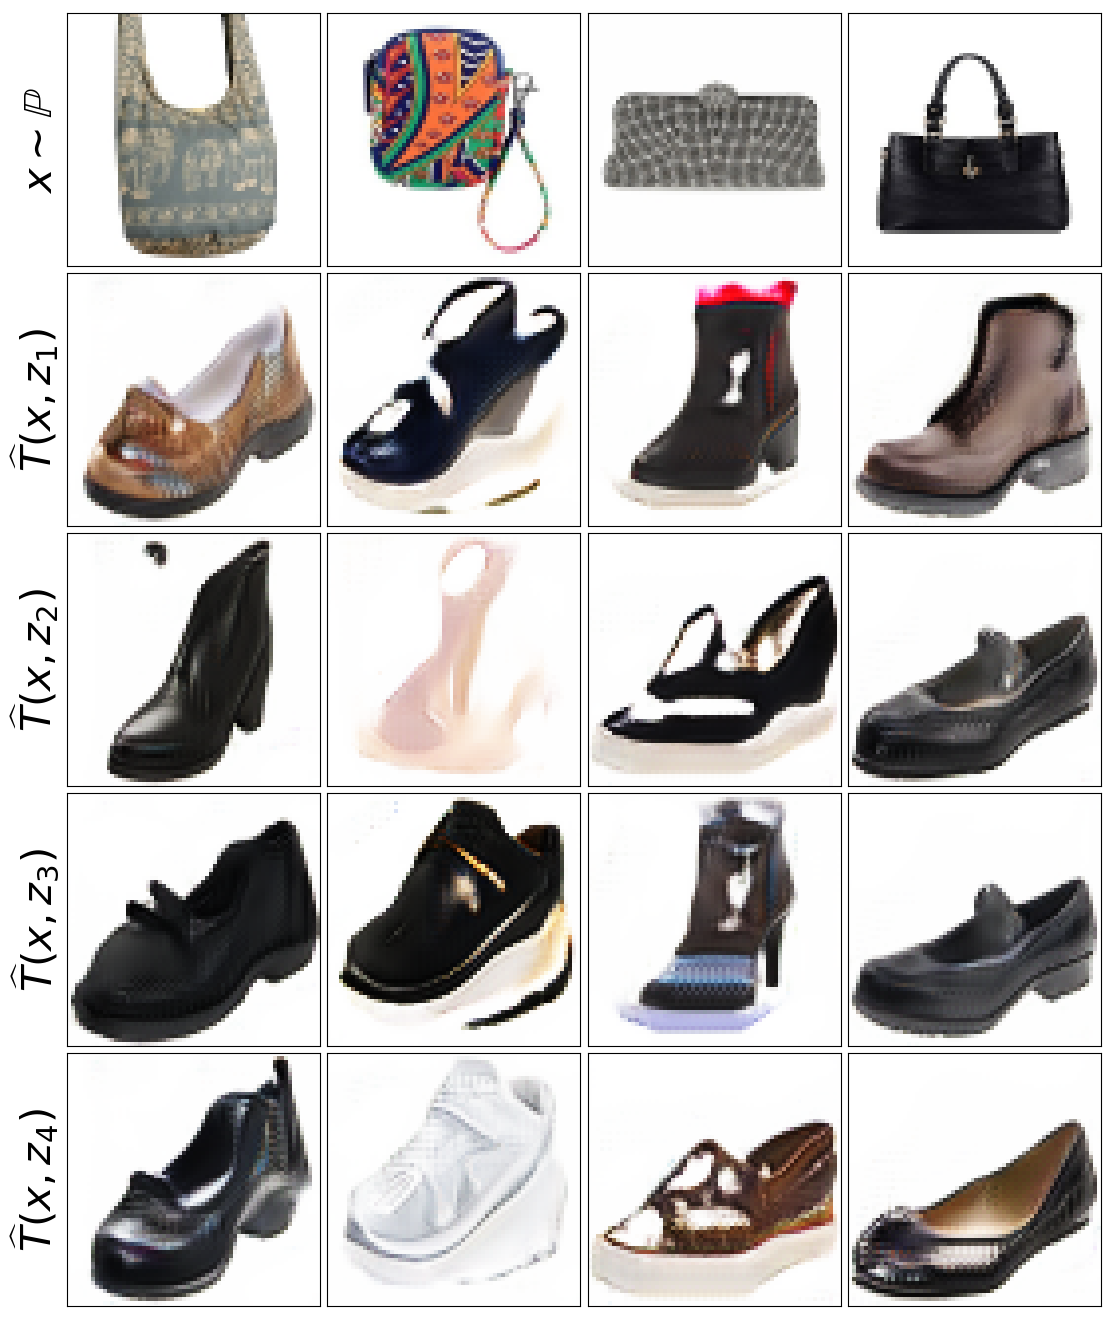

In [41]:
fig, axes = plt.subplots(5, 4, figsize=(11, 13), dpi=100)
X_tensor = real_X_test_numpy
Y_tensor = real_Y_test_numpy
Y_fake_tensor = Y_test_fakes

for j in range(4):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    #axes[0][j].get_yaxis().set_visible(False)

for i in range(4):
    for j in range(4):
        cur_img = Y_fake_tensor[i][j]

        axes[i + 1][j].imshow(cur_img)
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])
        #axes[i + 1][j].get_yaxis().set_visible(False)
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1, 0].set_ylabel(r'${}$'.format(title), fontsize=30)
    
fig.tight_layout(pad=0.001)    
plt.savefig("aug_cyclegan_test.png")